<a href="https://colab.research.google.com/github/Yihe0917/Quant_Assessment/blob/main/Quant_Assessment_Huang_Yihe_250307.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [80]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Tasks 1. Extract historical price data for the stocks MSFT, AAPL, NVDA, AMZN, GOOG, META, and TSLA
using the Yahoo Finance API (yfinance). The data should span from 2013-01-01 to 2023-12-31

In [81]:
def get_stock_data(tickers, start_date, end_date):
    data = yf.download(tickers, start=start_date, end=end_date)
    stock_prices = data["Close"]
    #print(data["Close"])  # Print the first few rows to check column names
    return stock_prices

tickers = ['MSFT', 'AAPL', 'NVDA', 'AMZN', 'GOOG', 'META', 'TSLA']
start_date = '2013-01-01'
end_date = '2023-12-31'

stock_data = get_stock_data(tickers, start_date, end_date)
#print(stock_data)

[*********************100%***********************]  7 of 7 completed


Task 2. Implement the Double Bollinger Band indicator to generate buy and sell signals based on the
specified strategy

In [82]:
def calculate_bollinger_bands(data, period, std_dev_mult):
    rolling_mean = data.rolling(window=period).mean()
    rolling_std = data.rolling(window=period).std()

    upper_band = rolling_mean + (rolling_std * std_dev_mult)
    lower_band = rolling_mean - (rolling_std * std_dev_mult)

    return pd.DataFrame({'Upper': upper_band, 'Lower': lower_band, 'Moving Average': rolling_mean})

period=20
std_dev_mult=2

In [83]:
def generate_trading_signals(data, upper_band, lower_band):
    signals = pd.Series(0, index=data.index)

    # Buy signal: Price crosses above the upper band
    signals[data > upper_band] = 1

    # Sell signal: Price crosses below the lower band
    signals[data < lower_band] = -1

    # To avoid consecutive signals, we only keep the signal when it changes
    signals = signals.replace(0, np.nan).ffill().fillna(0) #Forward fill
    signals = signals[signals.shift() != signals]


    return signals

Task 3. Design a backtesting loop to simulate trading with these signals. Assume an initial capital of
$10,000. The minimum transaction size is set at 1 share per trade

In [84]:
def backtest(data, signals, initial_capital, min_trade_size):
    positions = pd.Series(0, index=data.index)  # Number of shares held
    cash = initial_capital  # Start with initial capital
    portfolio_value = pd.Series(index=data.index, dtype='float64')  # Store portfolio value
    trades = []  # Store trade history

    for i, price in data.items():
        signal = signals.get(i, 0)  # Get signal, default to 0 if no signal for that date
        idx = data.index.get_loc(i)  # Get integer index of the timestamp

        # Get previous position (handle first row case)
        prev_position = positions.iloc[idx - 1] if idx > 0 else 0

        if signal == 1:  # Buy
            shares_to_buy = int(cash / price)  # Max shares we can buy
            shares_to_buy = max(shares_to_buy, min_trade_size)  # Ensure at least min_trade_size
            cost = shares_to_buy * price

            if cash >= cost:
                positions.loc[i] = prev_position + shares_to_buy  # Add shares
                cash -= cost
                trades.append({'date': i, 'action': 'buy', 'price': price, 'shares': shares_to_buy})
            else:
                positions.loc[i] = prev_position  # Not enough cash, hold

        elif signal == -1:  # Sell
            shares_to_sell = prev_position  # Sell all shares if we have any
            if shares_to_sell > 0:
                revenue = shares_to_sell * price
                cash += revenue
                positions.loc[i] = 0  # Sold all shares
                trades.append({'date': i, 'action': 'sell', 'price': price, 'shares': shares_to_sell})
            else:
                positions.loc[i] = prev_position  # No shares to sell, hold

        else:
            positions.loc[i] = prev_position  # Hold

        # Calculate portfolio value
        portfolio_value.loc[i] = cash + (positions.loc[i] * price)

    trades_df = pd.DataFrame(trades)
    return portfolio_value, trades_df


# Example Usage
initial_capital = 10000
min_trade_size = 1


Task 4: Compute the following performance metrics to assess the strategy's effectiveness:

In [85]:
import numpy as np
import pandas as pd

def calculate_performance_metrics(portfolio_values, risk_free_rate):
    """
    Calculate key performance metrics for a portfolio or single stock.

    Parameters:
    - portfolio_values (pd.Series): Time series of portfolio values.
    - risk_free_rate (float): Annual risk-free rate (default: 2%).

    Returns:
    - dict: Dictionary containing performance metrics.
    """
    returns = portfolio_values.pct_change().dropna()  # Daily returns

    if returns.empty or portfolio_values.isna().all():
        return {
            "total_return": 0, "annualized_return": 0, "annualized_volatility": 0,
            "sharpe_ratio": 0, "sortino_ratio": 0, "max_drawdown": 0, "calmar_ratio": 0
        }

    # Fix index issues by using .iloc[]
    initial_value = portfolio_values.iloc[0]
    final_value = portfolio_values.iloc[-1]

    # **1. Total Return**
    total_return = (final_value - initial_value) / initial_value

    # **2. Annualized Return (CAGR)**
    num_days = len(portfolio_values)
    annualized_return = (final_value / initial_value) ** (252 / num_days) - 1 if num_days > 0 else 0

    # **3. Annualized Volatility**
    annualized_volatility = returns.std() * np.sqrt(252) if returns.std() != 0 else 0

    # **4. Sharpe Ratio**
    excess_returns = returns - (risk_free_rate / 252)  # Adjust for daily risk-free rate
    sharpe_ratio = excess_returns.mean() / annualized_volatility if annualized_volatility != 0 else 0

    # **5. Sortino Ratio** (Uses downside deviation instead of total volatility)
    downside_returns = returns[returns < 0]  # Only negative returns
    downside_volatility = downside_returns.std() * np.sqrt(252) if not downside_returns.empty else 0
    sortino_ratio = excess_returns.mean() / downside_volatility if downside_volatility != 0 else 0

    # **6. Maximum Drawdown (MDD)**
    rolling_max = portfolio_values.cummax()  # Peak portfolio value at each point
    drawdown = (portfolio_values - rolling_max) / rolling_max  # % drop from peak
    max_drawdown = drawdown.min() if not drawdown.isna().all() else 0  # Worst drawdown

    # **7. Calmar Ratio** (Annual return / Maximum Drawdown)
    calmar_ratio = annualized_return / abs(max_drawdown) if max_drawdown != 0 else 0

    # Store metrics in dictionary
    metrics = {
        "total_return": total_return,
        "annualized_return": annualized_return,
        "annualized_volatility": annualized_volatility,
        "sharpe_ratio": sharpe_ratio,
        "sortino_ratio": sortino_ratio,
        "max_drawdown": max_drawdown,
        "calmar_ratio": calmar_ratio
    }

    return metrics

# Example usage
risk_free_rate = 0.02  # Default 2% annual risk-free rate



Processing MSFT...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Processing AAPL...



[*********************100%***********************]  1 of 1 completed

Processing NVDA...



[*********************100%***********************]  1 of 1 completed

Processing AMZN...



[*********************100%***********************]  1 of 1 completed

Processing GOOG...



[*********************100%***********************]  1 of 1 completed

Processing META...



[*********************100%***********************]  1 of 1 completed

Processing TSLA...



Individual Stock Metrics:
MSFT: {'total_return': 2.695138037109375, 'annualized_return': 0.12636036115388394, 'annualized_volatility': 0.17011001988624674, 'sharpe_ratio': 0.002648661077406605, 'sortino_ratio': 0.002715092068541033, 'max_drawdown': -0.2592064783732085, 'calmar_ratio': 0.48748920916995303}
AAPL: {'total_return': 3.963881612586975, 'annualized_return': 0.1570387483829918, 'annualized_volatility': 0.19053133255907442, 'sharpe_ratio': 0.0030003846914436055, 'sortino_ratio': 0.0033507394293443636, 'max_drawdown': -0.31113915195903524, 'calmar_ratio': 0.5047219142760524}
NVDA: {'total_return': 11.629446459019183, 'annualized_return': 0.25970988543489804, 'annualized_volatility': 0.3195407661845883, 'sharpe_ratio': 0.003240464610654936, 'sortino_ratio': 0.0038643862842529966, 'max_drawdown': -0.5070489258438677, 'calmar_ratio': 0.5121988672053095}
AMZN: {'total_return': 2.8508629219055175, 'annualized_return': 0.1306012896390134, 'annualized_volatility': 0.22371291767743276,

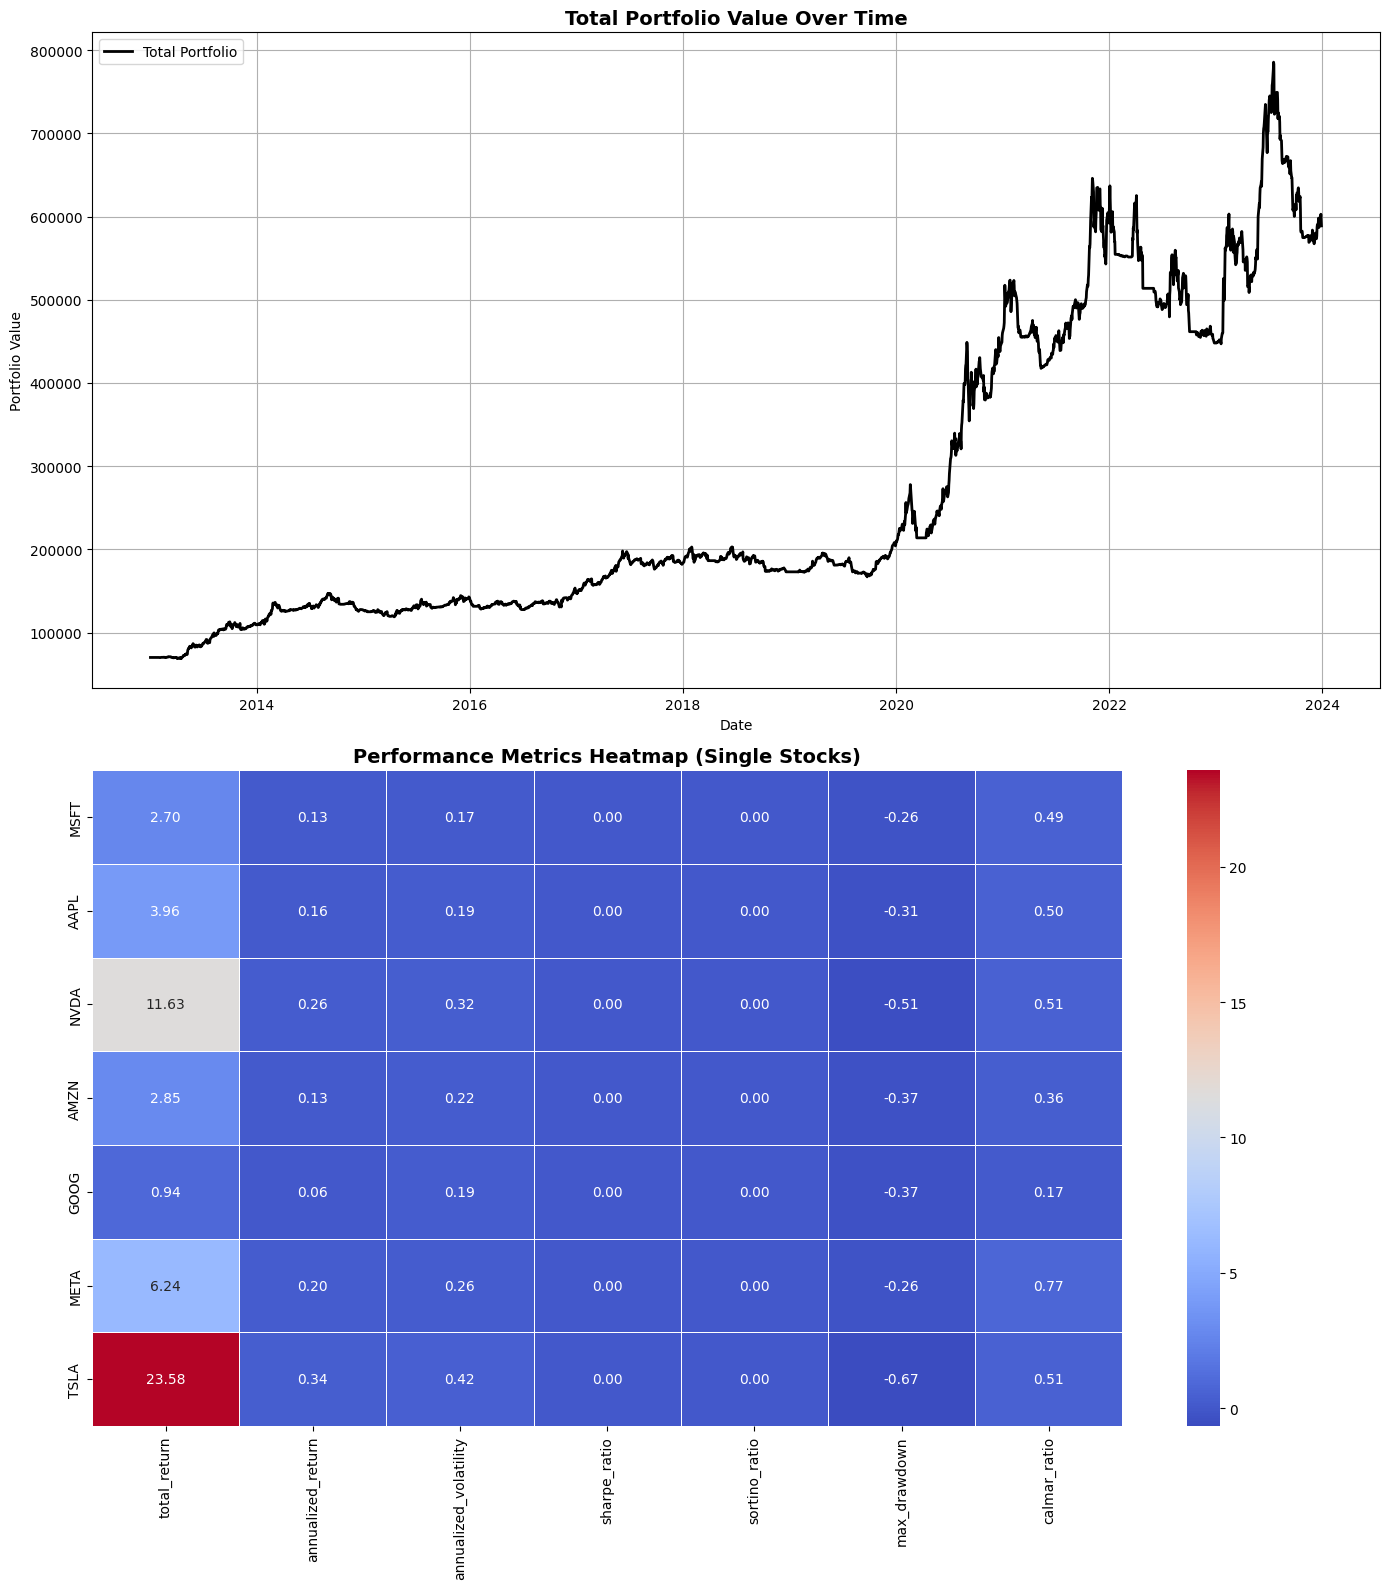

In [86]:
all_metrics = {}  # Stores individual stock performance metrics
all_portfolios = {}  # Stores individual stock portfolio values
all_trades = {}  # Stores trade history for each stock

portfolio_values = pd.DataFrame()  # To store total portfolio value over time

period = 20
std_dev_mult = 2
initial_capital = 10000
min_trade_size = 1
risk_free_rate = 0.02

for ticker in tickers:
    print(f"Processing {ticker}...")  # Log progress

    stock_data = get_stock_data([ticker], start_date, end_date)  # Fetch data for single ticker
    if ticker not in stock_data or stock_data[ticker].empty:
        print(f"Skipping {ticker}: No data available.")
        continue  # Skip this ticker if no data is found

    data = stock_data[ticker]
    bollinger_bands = calculate_bollinger_bands(data, period, std_dev_mult)
    signals = generate_trading_signals(data, bollinger_bands['Upper'], bollinger_bands['Lower'])

    if signals.empty:
        print(f"Skipping {ticker}: No trading signals generated.")
        continue  # Skip if no signals

    portfolio_value, trades = backtest(data, signals, initial_capital, min_trade_size)

    if portfolio_value.empty:
        print(f"Skipping {ticker}: No portfolio values generated.")
        continue  # Skip if no portfolio values

    # Store individual stock performance
    stock_metrics = calculate_performance_metrics(portfolio_value, risk_free_rate)
    all_metrics[ticker] = stock_metrics
    all_portfolios[ticker] = portfolio_value
    all_trades[ticker] = trades

    # Store portfolio values for aggregation
    portfolio_values[ticker] = portfolio_value

# Compute total portfolio value by summing all individual stock portfolios
if not portfolio_values.empty:
    total_portfolio_value = portfolio_values.sum(axis=1)  # Summing across all tickers at each time point
    portfolio_metrics = calculate_performance_metrics(total_portfolio_value, risk_free_rate)
else:
    total_portfolio_value = pd.Series(dtype=float)
    portfolio_metrics = {}

print("\nIndividual Stock Metrics:")
for ticker, metric in all_metrics.items():
    print(f"{ticker}: {metric}")

print("\nTotal Portfolio Metrics:")
print(portfolio_metrics)

# Convert individual stock metrics dictionary to DataFrame
metrics_df = pd.DataFrame.from_dict(all_metrics, orient='index')

# Ensure metrics_df is always a DataFrame
if isinstance(metrics_df, pd.Series):
    metrics_df = metrics_df.to_frame()

# Ensure all expected metrics are included
expected_metrics = ["sharpe_ratio", "sortino_ratio", "calmar_ratio"]
for metric in expected_metrics:
    if metric not in metrics_df.columns:
        metrics_df[metric] = np.nan  # Fill missing metrics with NaN to avoid KeyErrors

# Handle NaN values by replacing with 0
metrics_df = metrics_df.fillna(0)

# Exclude the total portfolio if it exists
if isinstance(metrics_df, pd.DataFrame) and "Total Portfolio" in metrics_df.index:
    metrics_df = metrics_df.drop(index="Total Portfolio")

# Create subplots
fig, ax = plt.subplots(2, 1, figsize=(14, 16))


# **1. Line Plot - Total Portfolio Value Over Time**
if not total_portfolio_value.empty:
    ax[0].plot(total_portfolio_value.index, total_portfolio_value.values, label="Total Portfolio", color="black", linewidth=2)
    ax[0].set_title("Total Portfolio Value Over Time", fontsize=14, fontweight='bold')
    ax[0].set_xlabel("Date")
    ax[0].set_ylabel("Portfolio Value")
    ax[0].legend()
    ax[0].grid()
else:
    ax[0].text(0.5, 0.5, "No portfolio data available", horizontalalignment='center', verticalalignment='center', transform=ax[1].transAxes)
    ax[0].set_title("Total Portfolio Value Over Time", fontsize=14, fontweight='bold')

# **3. Heatmap - Performance Metrics (Single Stocks)**
sns.heatmap(metrics_df, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5, ax=ax[1], cbar=True)
ax[1].set_title("Performance Metrics Heatmap (Single Stocks)", fontsize=14, fontweight='bold')

# Adjust layout
plt.tight_layout()
plt.show()
